In [1]:
import numba
import numpy as np
from math import exp
from pyfigtree import figtree

import matplotlib.pyplot as plt

In [2]:
# example problem
np.random.seed(0)
Nc = 1000
Ne = 2*Nc

source_points = np.random.random((Nc,2))
target_points = np.random.random((Ne,2))
c = np.random.random(Nc)
sig = np.ones(Nc)*0.05

xc = source_points[:,0]
yc = source_points[:,1]
xe = target_points[:,0]
ye = target_points[:,1]

## Direct approach

In [3]:
@numba.jit(nopython=True)
def u_eval(c, sig, xc, yc, xe, ye, support=5):
    m = len(xe)
    n = len(xc)
    ret = np.zeros(m)
    for i in range(m):
        for j in range(n):
            dist2 = (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2
            #if  dist2 > support**2 * sig[j]**2: continue
            ret[i] += c[j] * exp(-dist2 / sig[j]**2 )
    return ret

In [5]:
u1 = u_eval(c, sig, xc, yc, xe, ye)

In [6]:
%timeit -n 100 u_eval(c, sig, xc, yc, xe, ye)

32.6 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Threading approach

In [11]:
from threading import Thread

In [12]:
@numba.jit(nopython=True, nogil=True)
def _u_eval_thread(c, sig, xc, yc, xe, ye, sind, chunk_size, res, support=5):
    n = len(xc)
    for i in range(sind,sind+chunk_size):
        for j in range(n):
            dist2 = (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2
            if  dist2 > support**2 * sig[j]**2: continue
            res[i] += c[j] * exp( -0.5 * dist2 / sig[j]**2 )
            
def u_eval_thread(c, sig, xc, yc, xe, ye, n_thread=4):
    # array for results
    Ne = len(xe)
    res = np.zeros(Ne)
    
    # data size for each thread
    chunk_size = Ne // n_thread
    
    # starting index for each thread
    start_indexes = [i * chunk_size for i in range(n_thread)]
    
    threads = [Thread(target=_u_eval_thread, 
                  args=(c,sig,xc,yc,xe,ye,sind,chunk_size,res)) for sind in start_indexes]
    for thread in threads: thread.start()
    for thread in threads: thread.join()
        
    return res

In [13]:
 u2 = u_eval_thread(c, sig, xc, yc, xe, ye, n_thread=2)

In [14]:
%timeit -n 100 u_eval_thread(c, sig, xc, yc, xe, ye, n_thread=2)

8.8 ms ± 796 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## `figtree` approach

In [4]:
def u_eval_figtree(w, sig, xc, yc, xe, ye, epsilon=1e-10):
    centers = np.vstack([xc,yc]).T
    targets = np.vstack([xe,ye]).T
    ret = figtree(centers, targets, w, bandwidth=sig, epsilon=epsilon)
    return ret

In [17]:
tr = %timeit -o -n 5 figtree(source_points, target_points, c, bandwidth=0.05, epsilon=1e-10)

699 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [18]:
target_evaluation = figtree(source_points, target_points, c, bandwidth=0.05, epsilon=1e-10)

In [19]:
print("Difference between direct and figtree evaluation:", 
     np.max(np.abs(direct_evaluation-target_evaluation)))

Difference between direct and figtree evaluation: 2.8842173094290047e-09


## Times comparison

In [100]:
times_direct = []
times_figtree = []
n_points = list(range(250, 10001, 250))

for Nc in n_points:
    # points generation
    Ne = 5*Nc
    source_points = np.random.random((Nc,2))
    target_points = np.random.random((Ne,2))
    c = np.random.random(Nc)
    sig = np.ones(Nc)*0.05
    xc = source_points[:,0]
    yc = source_points[:,1]
    xe = target_points[:,0]
    ye = target_points[:,1]
    
    # evaluating performance of direct evaluation
    print("Direct evaluation with N={0}".format(Nc))
    tr1 = %timeit -o -n 5 u_eval(c, sig, xc, yc, xe, ye)
    times_direct.append(tr1.average)
    print("\n")
    
    # evaluating performance of figtree evaluation
    print("Figtree evaluation with N={0}".format(Nc))
    tr2 = %timeit -o -n 5 figtree(source_points, target_points, c, bandwidth=0.05, epsilon=1e-10)
    times_figtree.append(tr2.average)
    print("\n")

Direct evaluation with N=250
5.61 ms ± 738 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Figtree evaluation with N=250
3.76 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Direct evaluation with N=500
18.8 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Figtree evaluation with N=500
10.7 ms ± 519 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Direct evaluation with N=750
41.7 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Figtree evaluation with N=750
22 ms ± 820 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Direct evaluation with N=1000
74.6 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Figtree evaluation with N=1000
42.1 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Direct evaluation with N=1250
122 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Figtree evaluation with N=1250
56.6 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 5 lo

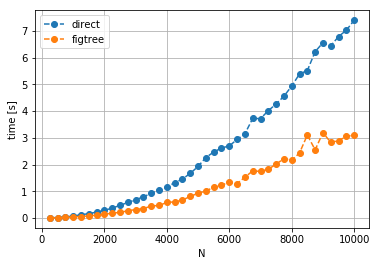

In [101]:
plt.plot(n_points, times_direct, "o--", label="direct")
plt.plot(n_points, times_figtree, "o--", label="figtree")
plt.grid()
plt.legend(loc="best")
plt.xlabel("N")
plt.ylabel("time [s]")
plt.show()

## `time` vs $\epsilon$ in `figtree` 

In [98]:
epsilon_values = [10**(-x) for x in range(0,17)]
times_figtree2 = []

# points generation
Nc = 5000
Ne = 5*Nc
source_points = np.random.random((Nc,2))
target_points = np.random.random((Ne,2))
c = np.random.random(Nc)
sig = np.ones(Nc)*0.05

for epsilon in epsilon_values:
    # evaluating performance of figtree evaluation
    print("Figtree evaluation with N={0}".format(Nc))
    tr = %timeit -o -n 10 figtree(source_points, target_points, c, bandwidth=0.05, epsilon=epsilon)
    times_figtree2.append(tr.average)
    print("\n")
    

Figtree evaluation with N=5000
9.64 ms ± 379 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Figtree evaluation with N=5000
77.5 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Figtree evaluation with N=5000
134 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Figtree evaluation with N=5000
209 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Figtree evaluation with N=5000
319 ms ± 37.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Figtree evaluation with N=5000
383 ms ± 9.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Figtree evaluation with N=5000
558 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Figtree evaluation with N=5000
736 ms ± 91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Figtree evaluation with N=5000
788 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Figtree evaluation with N=5000
866 ms ± 17.7 ms per loop (mean ± std. dev. of 7

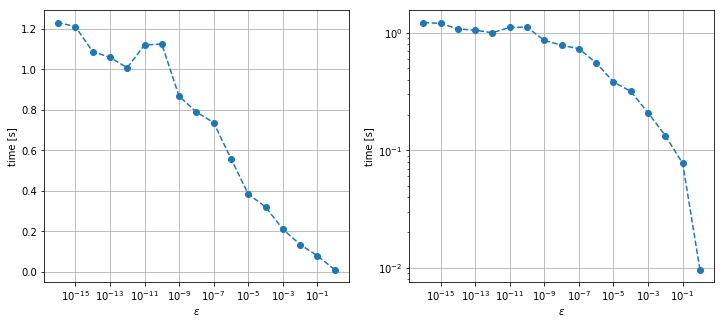

In [102]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.semilogx(epsilon_values, times_figtree2, "o--")
plt.grid()
plt.xlabel("$\epsilon$")
plt.ylabel("time [s]")
plt.subplot(122)
plt.loglog(epsilon_values, times_figtree2, "o--")
plt.grid()
plt.xlabel("$\epsilon$")
plt.ylabel("time [s]")
plt.show()

## `figtree` methods

In [103]:
# example problem
np.random.seed(0)
Nc = 10000
Ne = 5*Nc

source_points = np.random.random((Nc,2))
target_points = np.random.random((Ne,2))
c = np.random.random(Nc)
sig = np.ones(Nc)*0.05

In [110]:
%%timeit -n 10 
figtree(source_points, target_points, c, bandwidth=0.05, epsilon=1e-10, eval="direct")

1.54 s ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [111]:
%%timeit -n 10 
figtree(source_points, target_points, c, bandwidth=0.05, epsilon=1e-10, eval="direct-tree")

803 ms ± 72.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [112]:
%%timeit -n 10 
figtree(source_points, target_points, c, bandwidth=0.05, epsilon=1e-10, eval="IFGT")

659 ms ± 4.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [113]:
%%timeit -n 10 
figtree(source_points, target_points, c, bandwidth=0.05, epsilon=1e-10, eval="IFGT-tree")

797 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


***
***

In [7]:
times_figtree_m1 = []
times_figtree_m2 = []
times_figtree_m3 = []
times_figtree_m4 = []
n_points = list(range(250, 10001, 250))

for Nc in n_points:
    # points generation
    Ne = 5*Nc
    source_points = np.random.random((Nc,2))
    target_points = np.random.random((Ne,2))
    c = np.random.random(Nc)
    sig = np.ones(Nc)*0.05
    xc = source_points[:,0]
    yc = source_points[:,1]
    xe = target_points[:,0]
    ye = target_points[:,1]
    
    print("Number of points",Nc)
    
    # evaluating performance of figtree evaluation
    tr1 = %timeit -o -n 5 figtree(source_points, target_points, c, bandwidth=0.05, epsilon=1e-10, eval="direct")
    times_figtree_m1.append(tr1.average)
    
    # evaluating performance of figtree evaluation
    tr2 = %timeit -o -n 5 figtree(source_points, target_points, c, bandwidth=0.05, epsilon=1e-10, eval="direct-tree")
    times_figtree_m2.append(tr2.average)
    
    # evaluating performance of figtree evaluation
    tr3 = %timeit -o -n 5 figtree(source_points, target_points, c, bandwidth=0.05, epsilon=1e-10, eval="IFGT")
    times_figtree_m3.append(tr3.average)
    
    # evaluating performance of figtree evaluation
    tr4 = %timeit -o -n 5 figtree(source_points, target_points, c, bandwidth=0.05, epsilon=1e-10, eval="IFGT-tree")
    times_figtree_m4.append(tr4.average)

Number of points 250
5.38 ms ± 673 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
2.79 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
10.2 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
10.2 ms ± 655 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
Number of points 500
20.3 ms ± 823 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
10.3 ms ± 530 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
48 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
51.2 ms ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
Number of points 750
45.6 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
21.6 ms ± 637 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
94 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
100 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
Number of points 1000
120 ms ± 34 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
62.9 ms ± 11.6 ms pe

1.71 s ± 139 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
Number of points 7250
4.38 s ± 81.1 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
2.03 s ± 127 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
1.55 s ± 39.8 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
1.57 s ± 38 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
Number of points 7500
4.82 s ± 154 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
2.25 s ± 34.9 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
1.67 s ± 41.9 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
2 s ± 260 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
Number of points 7750
5.59 s ± 773 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
2.22 s ± 61.7 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
1.64 s ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
1.76 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
Number of points 8000
6.46 s ± 496 ms per loop (

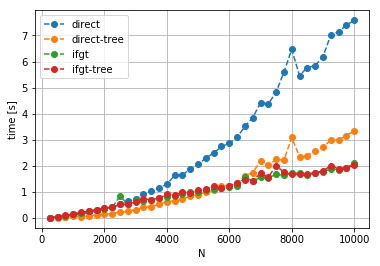

In [8]:
plt.plot(n_points, times_figtree_m1, "o--", label="direct")
plt.plot(n_points, times_figtree_m2, "o--", label="direct-tree")
plt.plot(n_points, times_figtree_m3, "o--", label="ifgt")
plt.plot(n_points, times_figtree_m4, "o--", label="ifgt-tree")
plt.grid()
plt.legend(loc="best")
plt.xlabel("N")
plt.ylabel("time [s]")
plt.show()

## Comparison in low number of centers regime

In [8]:
# example problem
np.random.seed(0)
Nc = 250
Ne = 4*Nc

source_points = np.random.random((Nc,2))
target_points = np.random.random((Ne,2))
c = np.random.random(Nc)
sig = np.ones(Nc)*0.05

xc = source_points[:,0]
yc = source_points[:,1]
xe = target_points[:,0]
ye = target_points[:,1]

In [9]:
%timeit -n 100 u_eval(c, sig, xc, yc, xe, ye)

4.29 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%timeit -n 100 u_eval_figtree(c, 0.05, xc, yc, xe, ye)

3.27 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
